#### Repeat previous steps but use LDA with only nounjs

In [111]:
!pip install vaderSentiment

     -------------------------------------- 126.0/126.0 kB 3.6 MB/s eta 0:00:00


In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import string
import nltk
from nltk import WordNetLemmatizer
import spacy
import re
import bbcode
import json

import gensim
from gensim.test.utils import datapath
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import os
import pathlib
%matplotlib inline

In [2]:

final_df = pd.read_csv('C:\\Users\\Orie\\Desktop\\InstituteofData\\Capstone\\final_df.csv',index_col=0)

In [3]:
final_df = final_df[['timestamp_created','review','clean_reviews','2gram_reviews','3gram_reviews']]
final_df.head()

,timestamp_created,review,clean_reviews,2gram_reviews,3gram_reviews
0,1716229487,Remember Hades 1? Yeah the sequel's even bette...,"['remember', 'hades', 'one', 'yeah', 'sequel',...","['remember', 'hade', 'yeah', 'sequel', 'I', 'm...","['remember', 'hades_one', 'yeah', 'sequel', 'I..."
1,1716229128,Game is truly great and I couldn't RECOMMEND i...,"['truly', 'recommend', 'fr', 'correct', 'negat...","['truly', 'recommend', 'fr', 'correct', 'negat...","['truly', 'recommend', 'fr', 'correct', 'negat..."
2,1716228929,We need more companies making this style this way,"['need', 'companies', 'making', 'style', 'way']","['need', 'company', 'make', 'style', 'way']","['need', 'company', 'make', 'style', 'way']"
3,1716228834,I am fully prepared to face the backlash from ...,"['fully', 'prepared', 'face', 'backlash', 'rev...","['fully', 'prepared', 'face', 'backlash', 'rev...","['fully', 'prepared', 'face', 'backlash', 'rev..."
4,1716228806,Even in Early Access there's more content to e...,"['early', 'access', 'content', 'explore', 'had...","['early_access', 'content', 'explore', 'hade',...","['early_access_content', 'explore', 'hades_one..."


In [4]:
final_df['clean_reviews'] = final_df['clean_reviews'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) #n-grams underscores must be preserved for readability
final_df['2gram_reviews'] = final_df['2gram_reviews'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) 
final_df['3gram_reviews'] = final_df['3gram_reviews'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) 
#Reading in the DF from a CSV turned the list of words in each cell into string, so we have to remove the punctuation and split them again to get lists of terms

In [5]:
# Text Cleaning Redux

nlp = spacy.load("en_core_web_sm")
parser = bbcode.Parser()

#expand contractions
with open('C:\\Users\\Orie\\Desktop\\InstituteofData\\Capstone\\contra_dict.txt') as contra_dict:
    cList = json.load(contra_dict)

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text.lower())

#convert numbers to words

num_dict = {'0':'zero',
            '1':'one',
            '2':'two',
            '3':'three',
            #'i':'one',      skipped. Using Roman numeral 'i' will conflict with the pronoun "I", which is not a number
            'ii':'two',
            'iii':'three'   
            }

def num2word(d):
    
    if (len(d) == 1 and d in '0123')  or (d in ['ii','iii']):
        word = num_dict[d]
    
    elif (len(str(d))==1 and str(d) in '0123'):
        word = num_dict(str(d))
    
    else:
        word = d
    
    return word

#define stopwords

en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['good','better','great','lot','game','like','I','i'])
en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']]    #retain these for making n-grams, then remove afterwards

def remove_stopwords(doc):
    words = [num2word(w) for w in doc if w != '' and w not in en_stopwords]
    return words


#combine cleaning functions into one function
def parse_clean(text):
    parsed_text = parser.strip(text) #remove BBcode notations from text
    
    text = expandContractions(parsed_text) #expand contractions; return all text in lower case
    
    text = re.split(r'\W+',text) #separate words from punctuation (e.g. remove "'s" from "Cao Cao's")
    
    text = [num2word(w) for w in text] #convert single digits to words before word len check, or they will be lost
    
    #All word lengths should be >1 character and <= length of the longest word in the English language. It's common for people spam incoherent letters on the Internet.
    text = [word for word in text if word not in en_stopwords and len(word)>1 and len(word) <= len('pneumonoultramicroscopicsilicovolcanoconiosis')] 
    
    clean_text = [num2word(w) for w in text] #just in case any lone numbers appeared after cleaning
    
    return clean_text


def stop_clean(texts):
    texts = [parse_clean(doc) for doc in texts]
    texts = [remove_stopwords(doc) for doc in texts] #just in case, remove stopwords one more time
    
    return texts

#at this point we will make n-grams, then lemmatise using spacy since it can go by permitted postags

def spacy_lemma(bow,allowed_postags=['NOUN']): #can add any from https://spacy.io/api/annotation#pos-tagging but will be sticking to NOUN, VERB, ADJ
    
    lemma_doc = nlp(" ".join(bow)) 

    lemma_text = [token.text if '_' in token.text else token.lemma_ if token.pos_ in allowed_postags else '' for token in lemma_doc]
    
    return lemma_text

In [6]:
model2_df = final_df[['timestamp_created','review']]
model2_df.head()

,timestamp_created,review
0,1716229487,Remember Hades 1? Yeah the sequel's even bette...
1,1716229128,Game is truly great and I couldn't RECOMMEND i...
2,1716228929,We need more companies making this style this way
3,1716228834,I am fully prepared to face the backlash from ...
4,1716228806,Even in Early Access there's more content to e...


In [7]:
model2_df['clean_reviews'] = stop_clean(model2_df['review'])
model2_df.head()

C:\Users\Orie\AppData\Local\Temp\ipykernel_7752\1680552601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model2_df['clean_reviews'] = stop_clean(model2_df['review'])


,timestamp_created,review,clean_reviews
0,1716229487,Remember Hades 1? Yeah the sequel's even bette...,"[remember, hades, one, yeah, sequel, im, makin..."
1,1716229128,Game is truly great and I couldn't RECOMMEND i...,"[truly, recommend, fr, correct, negatives, pos..."
2,1716228929,We need more companies making this style this way,"[need, companies, making, style, way]"
3,1716228834,I am fully prepared to face the backlash from ...,"[fully, prepared, face, backlash, review, apol..."
4,1716228806,Even in Early Access there's more content to e...,"[early, access, content, explore, hades, one, ..."


In [8]:
#Now that the cleaner text is ready (only or mostly nouns), we create n-grams again

# Credit to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ for the n-grams code

# Build the bigram and trigram models
bigram = gensim.models.Phrases(list(model2_df['clean_reviews']), min_count=5, threshold=10) # feed a list of lists of words e.g. [['word1','word2'],['word3','word4'] to get bigrams]
trigram = gensim.models.Phrases(bigram[list(model2_df['clean_reviews'])], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [9]:
model2_df['2gram_reviews'] = make_trigrams(model2_df['clean_reviews'])
model2_df['2grams_nouns'] = model2_df['2gram_reviews'].map(lambda x: spacy_lemma(x))
model2_df['2grams_nouns_verbs'] = model2_df['2gram_reviews'].map(lambda x: spacy_lemma(x,allowed_postags=['NOUN','VERB']))
model2_df.head()

C:\Users\Orie\AppData\Local\Temp\ipykernel_7752\439389894.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model2_df['2gram_reviews'] = make_trigrams(model2_df['clean_reviews'])


,timestamp_created,review,clean_reviews,2gram_reviews,2grams_nouns,2grams_nouns_verbs
0,1716229487,Remember Hades 1? Yeah the sequel's even bette...,"[remember, hades, one, yeah, sequel, im, makin...","[remember, hades_one, yeah, sequel, im, making...","[, hades_one, , sequel, , , , theres_content, ...","[remember, hades_one, , sequel, , , make, ther..."
1,1716229128,Game is truly great and I couldn't RECOMMEND i...,"[truly, recommend, fr, correct, negatives, pos...","[truly, recommend, fr, correct, negatives, pos...","[, , , , negative, post, negative_review, art_...","[, recommend, , , negative, post, negative_rev..."
2,1716228929,We need more companies making this style this way,"[need, companies, making, style, way]","[need, companies, making, style, way]","[, company, , style, way]","[need, company, make, style, way]"
3,1716228834,I am fully prepared to face the backlash from ...,"[fully, prepared, face, backlash, review, apol...","[fully, prepared, face, backlash, review, apol...","[, , face, backlash, review, , , , knee, defen...","[, , face, backlash, review, apologize, refuse..."
4,1716228806,Even in Early Access there's more content to e...,"[early, access, content, explore, hades, one, ...","[early_access_content, explore, hades_one, wor...","[early_access_content, , hades_one, worth_pric...","[early_access_content, explore, hades_one, wor..."


In [10]:
en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['good','better','great','lot','game','like','I','i','one','two','three']) #after making n-grams, removing numbers should reduce noise

model2_df['2grams_nouns'] = model2_df['2grams_nouns'].map(lambda x: remove_stopwords(x)) #removes blanks as well
model2_df['2grams_nouns_verbs'] = model2_df['2grams_nouns_verbs'].map(lambda x: remove_stopwords(x)) 

In [12]:
model2_df.head()

,timestamp_created,review,clean_reviews,2gram_reviews,2grams_nouns,2grams_nouns_verbs
0,1716229487,Remember Hades 1? Yeah the sequel's even bette...,"[remember, hades, one, yeah, sequel, im, makin...","[remember, hades_one, yeah, sequel, im, making...","[hades_one, sequel, theres_content, level, var...","[remember, hades_one, sequel, theres_content, ..."
1,1716229128,Game is truly great and I couldn't RECOMMEND i...,"[truly, recommend, fr, correct, negatives, pos...","[truly, recommend, fr, correct, negatives, pos...","[negative, post, negative_review, art_style, e...","[recommend, negative, post, negative_review, a..."
2,1716228929,We need more companies making this style this way,"[need, companies, making, style, way]","[need, companies, making, style, way]","[company, style, way]","[need, company, style, way]"
3,1716228834,I am fully prepared to face the backlash from ...,"[fully, prepared, face, backlash, review, apol...","[fully, prepared, face, backlash, review, apol...","[face, backlash, review, knee, defend, nostalg...","[face, backlash, review, apologize, refuse, be..."
4,1716228806,Even in Early Access there's more content to e...,"[early, access, content, explore, hades, one, ...","[early_access_content, explore, hades_one, wor...","[early_access_content, hades_one, worth_price,...","[early_access_content, explore, hades_one, wor..."


#### LDA Model - 2grams- Nouns Only

In [13]:
#build dictionary and corpus from 3gram dataset, NOUNS only with filter_extremes()

documents = list(model2_df['2grams_nouns'])
dictionary = gensim.corpora.Dictionary(documents)
dictionary.filter_extremes(no_below = 5,no_above=0.5) #trying with default settings
corpus = [dictionary.doc2bow(word) for word in documents]

In [14]:
# LDA model parameters -- we will go with just 5 topics to keep the model more generalised
num_topics = 5
passes = 100
eval_every = None #Evaluation will happen later so no need to evaluate while training

In [15]:
#NOTE: LDAMultiCore; set workers = n-1 (where n is your number of cores)

%time ldamodel1 = LdaMulticore(corpus, num_topics=num_topics, id2word = dictionary, passes=passes, alpha='asymmetric',eval_every=eval_every,workers=3)

# Check resulting topics.
topic_list = ldamodel1.print_topics(num_topics=num_topics, num_words=15)
for index, i in enumerate(topic_list):
    str1 = str(i[1])
    for c in "0123456789+*\".":
        str1 = str1.replace(c, "")
    str1 = str1.replace("  ", " ")
    print(str1)

CPU times: total: 1min 42s
Wall time: 1min 46s
love hades_one _ early_access death_chronos content hour play time fun year day sequel supergiant release
hade hades_two time early_access sequel supergiant_games liked_hades fan masterpiece supergiant banger title goty experience developer
character story gameplay combat way music mechanic weapon hades_one design art world boon style fun
hade thing hades_one weapon fun story change way bit boon character mechanic early_access hades_two stuff
boon weapon enemy time attack boss dash thing damage way run use spoiler hades_one resource


In [16]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel1.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda1 = CoherenceModel(model=ldamodel1, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda1 = coherence_model_lda1.get_coherence()
print('\nCoherence Score: ', coherence_lda1)


Perplexity:  -6.82967649075424

Coherence Score:  0.6863804108502676


In [18]:
#save the model

newpath = 'C:/Users/Orie/Desktop/InstituteofData/Capstone/nouns_only/model1' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
    
ldamodel1.save('C:/Users/Orie/Desktop/InstituteofData/Capstone/nouns_only/model1/model1.model')

#Usable model with good topics! Very similar to topics found in first run and arguably better!

In [19]:
model2_df.to_csv('C:/Users/Orie/Desktop/InstituteofData/Capstone/model2_df.csv')

### Model Validation

In [20]:

#load dataset, which was previously cleaned in Modelling 3rd Run
model2_df = pd.read_csv('C:/Users/Orie/Desktop/InstituteofData/Capstone/model2_df.csv',index_col=0)

#reload model  (Noun only 2-gram)
lda_model = LdaMulticore.load('C:/Users/Orie/Desktop/InstituteofData/Capstone/nouns_only/model1/model1.model')

In [21]:
model_topics = lda_model.show_topics(formatted=False)
for line in lda_model.print_topics(num_words=15):
    print(str(line)+'\n')

(0, '0.034*"love" + 0.027*"hades_one" + 0.026*"10_10" + 0.021*"early_access" + 0.020*"death_chronos" + 0.019*"content" + 0.017*"hour" + 0.017*"play" + 0.016*"time" + 0.015*"fun" + 0.015*"year" + 0.011*"day" + 0.011*"sequel" + 0.009*"supergiant" + 0.008*"release"')

(1, '0.142*"hade" + 0.132*"hades_two" + 0.035*"time" + 0.033*"early_access" + 0.031*"sequel" + 0.020*"supergiant_games" + 0.013*"liked_hades" + 0.012*"fan" + 0.011*"masterpiece" + 0.010*"supergiant" + 0.009*"banger" + 0.008*"title" + 0.007*"goty" + 0.007*"experience" + 0.007*"developer"')

(2, '0.047*"character" + 0.036*"story" + 0.030*"gameplay" + 0.023*"combat" + 0.018*"way" + 0.014*"music" + 0.014*"mechanic" + 0.013*"weapon" + 0.012*"hades_one" + 0.010*"design" + 0.009*"art" + 0.008*"world" + 0.007*"boon" + 0.007*"style" + 0.007*"fun"')

(3, '0.037*"hade" + 0.027*"thing" + 0.025*"hades_one" + 0.022*"weapon" + 0.021*"fun" + 0.017*"story" + 0.013*"change" + 0.013*"way" + 0.013*"bit" + 0.012*"boon" + 0.011*"character" + 0.01

In [22]:
model2_df.head()

,timestamp_created,review,clean_reviews,2gram_reviews,2grams_nouns,2grams_nouns_verbs
0,1716229487,Remember Hades 1? Yeah the sequel's even bette...,"['remember', 'hades', 'one', 'yeah', 'sequel',...","['remember', 'hades_one', 'yeah', 'sequel', 'i...","['hades_one', 'sequel', 'theres_content', 'lev...","['remember', 'hades_one', 'sequel', 'theres_co..."
1,1716229128,Game is truly great and I couldn't RECOMMEND i...,"['truly', 'recommend', 'fr', 'correct', 'negat...","['truly', 'recommend', 'fr', 'correct', 'negat...","['negative', 'post', 'negative_review', 'art_s...","['recommend', 'negative', 'post', 'negative_re..."
2,1716228929,We need more companies making this style this way,"['need', 'companies', 'making', 'style', 'way']","['need', 'companies', 'making', 'style', 'way']","['company', 'style', 'way']","['need', 'company', 'style', 'way']"
3,1716228834,I am fully prepared to face the backlash from ...,"['fully', 'prepared', 'face', 'backlash', 'rev...","['fully', 'prepared', 'face', 'backlash', 'rev...","['face', 'backlash', 'review', 'knee', 'defend...","['face', 'backlash', 'review', 'apologize', 'r..."
4,1716228806,Even in Early Access there's more content to e...,"['early', 'access', 'content', 'explore', 'had...","['early_access_content', 'explore', 'hades_one...","['early_access_content', 'hades_one', 'worth_p...","['early_access_content', 'explore', 'hades_one..."


In [23]:
#Turn data from strings back into lists (only for the lists we want to use)
model2_df['clean_reviews'] = model2_df['clean_reviews'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split())
model2_df['2grams_nouns'] = model2_df['2grams_nouns'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) 

In [26]:
documents = list(model2_df['2grams_nouns'])
dictionary = gensim.corpora.Dictionary(documents)

#IMPORTANT! If you filtered extremes when CREATING the model, you must give it back EXACTLY the same dictionary or else it may not work with lda_model[corpus]!

dictionary_saved = gensim.corpora.Dictionary.load('C:\\Users\\Orie\\Desktop\\InstituteofData\\Capstone\\nouns_only\\model1\\model1.model.id2word') #this dictionary already had filter_extremes() applied during training step 

corpus = [dictionary_saved.doc2bow(text) for text in documents]

In [27]:
topic_list = lda_model.print_topics(num_topics=5, num_words=15)
for index, i in enumerate(topic_list):
    str1 = str(i[1])
    for c in "0123456789+*\".":
        str1 = str1.replace(c, "")
    str1 = str1.replace("  ", " ")
    print(str1)

love hades_one _ early_access death_chronos content hour play time fun year day sequel supergiant release
hade hades_two time early_access sequel supergiant_games liked_hades fan masterpiece supergiant banger title goty experience developer
character story gameplay combat way music mechanic weapon hades_one design art world boon style fun
hade thing hades_one weapon fun story change way bit boon character mechanic early_access hades_two stuff
boon weapon enemy time attack boss dash thing damage way run use spoiler hades_one resource


In [40]:
topic_dict = {'0':'Sequel/Release Date',
              '1':'Developer/Title Praise',
              '2':'Environmental Setting',
              '3':'Story',
              '4':'Gameplay',
             }

#created a dictionary so I can show topic names instead of numbers, without any complicated code

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # this is the dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                new_row = pd.Series([topic_dict[str(topic_num)], round(prop_topic, 4), topic_keywords])
                new_row_df = new_row.to_frame().T
                sent_topics_df = pd.concat([sent_topics_df, new_row_df], ignore_index=True)
                
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    orig_contents = pd.Series(model2_df['review'])
    docs = pd.Series(documents)
    sent_topics_df = pd.concat([sent_topics_df,docs, orig_contents], axis=1)
    return(sent_topics_df)

In [43]:
#generate dataframe
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents)

In [44]:
len(df_dominant_topic)

14291

In [42]:
# Format dataframe
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['document_no', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'tokens','original_text']

df_dominant_topic['num_tokens']=df_dominant_topic['tokens'].map(lambda x: len(x))

df_dominant_topic['unique_tokens']=df_dominant_topic['tokens'].map(lambda x: list(set(x)))
df_dominant_topic['num_unique_tokens']=df_dominant_topic['unique_tokens'].map(lambda x: len(x))

df_dominant_topic = df_dominant_topic[['dominant_topic','original_text','topic_perc_contrib','tokens','num_tokens','unique_tokens','num_unique_tokens','keywords']]


# Show dataframe
df_dominant_topic.head(10)

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
0,Sequel/Release Date,Remember Hades 1? Yeah the sequel's even bette...,0.5995,"[hades_one, sequel, theres_content, level, var...",9,"[character, hades_one, hot_gods, variety, trus...",9,"love, hades_one, 10_10, early_access, death_ch..."
1,Gameplay,Game is truly great and I couldn't RECOMMEND i...,0.6659,"[negative, post, negative_review, art_style, e...",17,"[post, projectile, effect, beauty, art_style, ...",15,"boon, weapon, enemy, time, attack, boss, dash,..."
2,Environmental Setting,We need more companies making this style this way,0.5012,"[company, style, way]",3,"[company, style, way]",3,"character, story, gameplay, combat, way, music..."
3,Gameplay,I am fully prepared to face the backlash from ...,0.5034,"[face, backlash, review, knee, defend, nostalg...",200,"[target, hades_two, favor, pigeon, ridiculous,...",141,"boon, weapon, enemy, time, attack, boss, dash,..."
4,Sequel/Release Date,Even in Early Access there's more content to e...,0.49,"[early_access_content, hades_one, worth_price,...",9,"[incentive, hades_one, early_access_content, b...",9,"love, hades_one, 10_10, early_access, death_ch..."
5,Gameplay,"For early access, Hades 2 has a huge amount of...",0.3256,"[early_access_hades_two, content, fence, recom...",109,"[h2, instead_spamming, content, ability, darre...",94,"boon, weapon, enemy, time, attack, boss, dash,..."
6,Developer/Title Praise,Can't wait for full version,0.5789,[version],1,[version],1,"hade, hades_two, time, early_access, sequel, s..."
7,Sequel/Release Date,"If anything, it's somehow [i]even gayer[/i] th...",0.3328,[],0,[],0,"love, hades_one, 10_10, early_access, death_ch..."
8,Gameplay,"This game is amazing, and I can't recommend it...",0.8897,"[nitpick, skill_issue, aoe, attack, boss, mobi...",7,"[defense, boss, mobility, attack, aoe, skill_i...",7,"boon, weapon, enemy, time, attack, boss, dash,..."
9,Environmental Setting,Great soundtrack and combat feeling,0.723,"[combat, feeling]",2,"[feeling, combat]",2,"character, story, gameplay, combat, way, music..."


In [45]:
df_dominant_topic.tail(10)

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
14281,Sequel/Release Date,Already really fun. Cant wait to see what come...,0.8329,"[fun, wait_comes, update]",3,"[fun, wait_comes, update]",3,"love, hades_one, 10_10, early_access, death_ch..."
14282,Sequel/Release Date,This game really is an improvement to the firs...,0.637,"[improvement, hade, bath, year]",4,"[improvement, hade, bath, year]",4,"love, hades_one, 10_10, early_access, death_ch..."
14283,Sequel/Release Date,THIS GAME IS SO INSANE OMG,0.6664,[omg],1,[omg],1,"love, hades_one, 10_10, early_access, death_ch..."
14284,Story,Awesome game. The balance between difficulty a...,0.3752,"[balance, difficulty, opinion, reference, myth...",9,"[difficulty, reference, opinion, mythology, ha...",8,"hade, thing, hades_one, weapon, fun, story, ch..."
14285,Environmental Setting,Engaging Gameplay? ✅\r\nSuper fun weapons and ...,0.8566,"[gameplay, super_fun, weapon, fun, horny]",5,"[gameplay, weapon, fun, horny, super_fun]",5,"character, story, gameplay, combat, way, music..."
14286,Sequel/Release Date,LET ME ROMANCE THE SPIDER ALREADY,0.6663,[let_romance],1,[let_romance],1,"love, hades_one, 10_10, early_access, death_ch..."
14287,Gameplay,Love it! Only one complaint: why won't you let...,0.823,"[complaint, mash, button, force, calorie, down...",6,"[button, downbutton, complaint, force, mash, c...",6,"boon, weapon, enemy, time, attack, boss, dash,..."
14288,Sequel/Release Date,Amazing for an Early Access game. There is WAY...,0.3739,"[amazing_early_access, way, content, hades_one...",25,"[wait_release, keepsake, playthrough, way, pla...",24,"love, hades_one, 10_10, early_access, death_ch..."
14289,Developer/Title Praise,"Hades 2 is a masterclass in game design, build...",0.4926,"[hades_two, masterclass, design, foundation, o...",27,"[sense, masterclass, hades_two, character, lay...",25,"hade, hades_two, time, early_access, sequel, s..."
14290,Story,After a couple 100 hours in Hades (not even 10...,0.7964,"[couple, 100_hours, hade, xd, core_gameplay, e...",48,"[boss, keepsake, monster, criticism, loved_had...",45,"hade, thing, hades_one, weapon, fun, story, ch..."


### Topic Misclassification

In [46]:
check_tokens = df_dominant_topic['num_tokens'].median() #middle point of the token count data will be the cutoff

In [80]:
# get all documents with num_token equal to median or fewer of the dataset.

tokens_df = df_dominant_topic[df_dominant_topic['num_tokens']<=check_tokens]
tokens_df.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
2,Environmental Setting,We need more companies making this style this way,0.5012,"[company, style, way]",3,"[company, style, way]",3,"character, story, gameplay, combat, way, music..."
6,Developer/Title Praise,Can't wait for full version,0.5789,[version],1,[version],1,"hade, hades_two, time, early_access, sequel, s..."
7,Sequel/Release Date,"If anything, it's somehow [i]even gayer[/i] th...",0.3328,[],0,[],0,"love, hades_one, 10_10, early_access, death_ch..."
9,Environmental Setting,Great soundtrack and combat feeling,0.723,"[combat, feeling]",2,"[feeling, combat]",2,"character, story, gameplay, combat, way, music..."
11,Sequel/Release Date,never played hades 1 but this game fire,0.665,[hades_one],1,[hades_one],1,"love, hades_one, 10_10, early_access, death_ch..."


In [81]:
tokens_df.to_csv('C:/Users/Orie/Desktop/InstituteofData/Capstone/tokens_df.csv')

In [48]:
#check class balance
cls_bal = tokens_df['dominant_topic'].value_counts(normalize=True)
print(cls_bal)

dominant_topic
Sequel/Release Date       0.625975
Developer/Title Praise    0.223609
Environmental Setting     0.061102
Story                     0.054862
Gameplay                  0.034451
Name: proportion, dtype: float64


Text(0.5, 0, '% of Reviews')

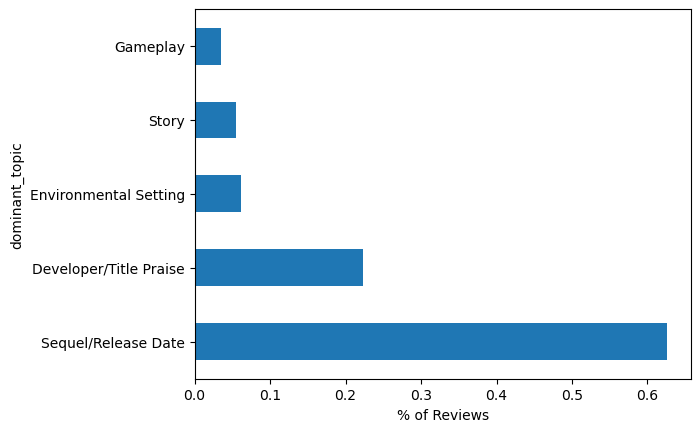

In [117]:
cls_bal.plot(kind='barh')
plt.xlabel('% of Reviews')

In [52]:
#There appears to be significant class imbalance. However, this isn't necessarily due to misclassification. 
#Most reviews are expected to talk about how a game lives up to the series it is from.
#will sample assuming equal probability first, seeing as the topics are not all confirmed to be correctly classified.

sample_tokens_df = tokens_df.sample(frac=0.1,random_state=1337) #take 10% of the data and sample it (according to http://www.raosoft.com/samplesize.html, 193 samples give ~7% margin of error)
sample_tokens_df.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
11218,Gameplay,melinoe just one chance please,0.5593,[chance],1,[chance],1,"boon, weapon, enemy, time, attack, boss, dash,..."
363,Sequel/Release Date,its perfect i love it!!!!!!!,0.6661,[love],1,[love],1,"love, hades_one, 10_10, early_access, death_ch..."
4222,Sequel/Release Date,"great game, just like the first one.",0.3328,[],0,[],0,"love, hades_one, 10_10, early_access, death_ch..."
12254,Developer/Title Praise,"Better than the first, it's an instant buy",0.6146,[instant_buy],1,[instant_buy],1,"hade, hades_two, time, early_access, sequel, s..."
3610,Sequel/Release Date,"It's not perfect, but it's really damn good.",0.3328,[],0,[],0,"love, hades_one, 10_10, early_access, death_ch..."


In [51]:
sample_tokens_df.to_csv('C:\\Users\\Orie\\Desktop\\InstituteofData\\Capstone\\sample_tokens_df.csv')

In [55]:
#manually label sampling dataframe, then import back in
#Only entered in 400 entries

sample_token_mod_df = pd.read_csv('C:\\Users\\Orie\\Desktop\\InstituteofData\\Capstone\\sample_tokens_df_mod.csv',index_col=0)

In [56]:
sample_token_mod_df.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords,correct
11218,Gameplay,melinoe just one chance please,0.5593,['chance'],1,['chance'],1,"boon, weapon, enemy, time, attack, boss, dash,...",1
363,Sequel/Release Date,its perfect i love it!!!!!!!,0.6661,['love'],1,['love'],1,"love, hades_one, 10_10, early_access, death_ch...",1
4222,Sequel/Release Date,"great game, just like the first one.",0.3328,[],0,[],0,"love, hades_one, 10_10, early_access, death_ch...",1
12254,Developer/Title Praise,"Better than the first, it's an instant buy",0.6146,['instant_buy'],1,['instant_buy'],1,"hade, hades_two, time, early_access, sequel, s...",1
3610,Sequel/Release Date,"It's not perfect, but it's really damn good.",0.3328,[],0,[],0,"love, hades_one, 10_10, early_access, death_ch...",1


In [57]:
samp_df = sample_token_mod_df.groupby(['num_tokens','correct'],as_index=False).count()[['num_tokens','correct','dominant_topic']] #To get row count, use any other column as last item in list

In [58]:
samp_df.columns = ['num_tokens','correct','count']

samp_df

,num_tokens,correct,count
0,0,0,24
1,0,1,36
2,1,0,46
3,1,1,73
4,2,0,55
5,2,1,69
6,3,0,36
7,3,1,60


In [63]:
samp_perc_dict = {'num_tokens':[],'correct':[],'wrong':[],'total':[],'ms_cls_rate (%)':[]}

for i in range(6):
    # Filter the DataFrame for the given num_tokens and correct counts
    filtered_df = samp_df[(samp_df['num_tokens'] == i) & (samp_df['correct'] == 1)]
    
    # Get the correct token count, handle case where filtered_df might be empty
    token_correct = filtered_df['count'].sum() if not filtered_df.empty else 0
    
    # Get the total token count for the given num_tokens
    token_total = samp_df[samp_df['num_tokens'] == i]['count'].sum()
    
    # Calculate wrong token count
    token_wrong = token_total - token_correct
    
    # Append values to the dictionary
    samp_perc_dict['num_tokens'].append(i)
    samp_perc_dict['correct'].append(token_correct)
    samp_perc_dict['wrong'].append(token_wrong)
    samp_perc_dict['total'].append(token_total)
    
    # Calculate misclassification rate, handle division by zero
    if token_total > 0:
        ms_cls_rate = (token_wrong / token_total) * 100
    else:
        ms_cls_rate = 0
    samp_perc_dict['ms_cls_rate (%)'].append(ms_cls_rate)

# Output the result
samp_perc_dict

{'num_tokens': [0, 1, 2, 3, 4, 5],
 'correct': [36, 73, 69, 60, 0, 0],
 'wrong': [24, 46, 55, 36, 0, 0],
 'total': [60, 119, 124, 96, 0, 0],
 'ms_cls_rate (%)': [40.0, 38.655462184873954, 44.354838709677416, 37.5, 0, 0]}

In [64]:
samp_perc_df = pd.DataFrame(samp_perc_dict)
samp_perc_df

,num_tokens,correct,wrong,total,ms_cls_rate (%)
0,0,36,24,60,40.000000
1,1,73,46,119,38.655462
2,2,69,55,124,44.354839
3,3,60,36,96,37.500000
4,4,0,0,0,0.000000
5,5,0,0,0,0.000000


C:\Users\Orie\AppData\Local\Temp\ipykernel_7752\3876121253.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


[Text(0, 0.0, '0%'),
 Text(0, 0.05, '5%'),
 Text(0, 0.1, '10%'),
 Text(0, 0.15000000000000002, '15%'),
 Text(0, 0.2, '20%'),
 Text(0, 0.25, '25%'),
 Text(0, 0.30000000000000004, '30%'),
 Text(0, 0.35000000000000003, '35%'),
 Text(0, 0.4, '40%'),
 Text(0, 0.45, '45%')]

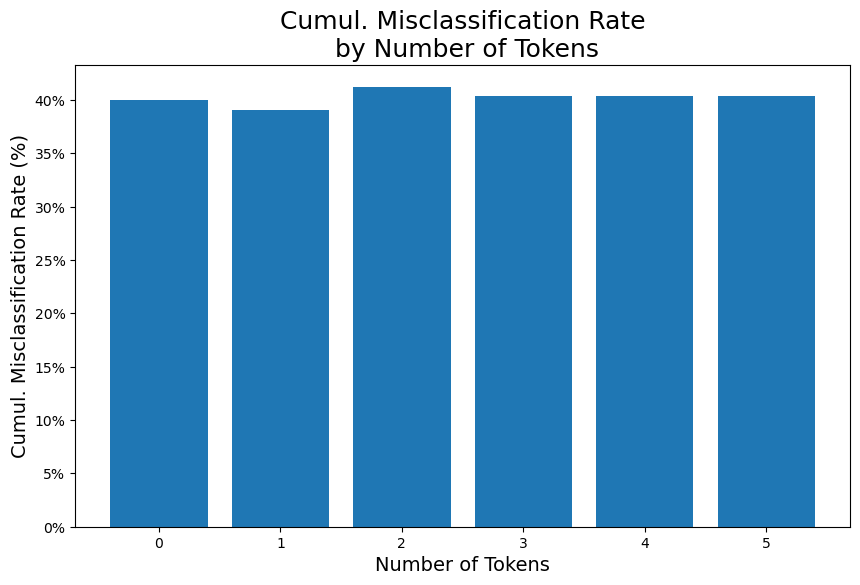

In [66]:
#from the sample, reviews with num_tokens 0, 1, and 3 tokens seem to have the worst misclassification rates.
#However, since the sample for each class is so small, I will assess this data cumulatively...

cum_ms_cls_rate = np.cumsum(samp_perc_df['wrong'])/np.cumsum(samp_perc_df['total']) #cumulative misclassification rate

plt.figure(figsize=(10,6))
plt.bar(x=range(0,6),height=cum_ms_cls_rate)
plt.xlabel('Number of Tokens',fontsize = 14)
plt.ylabel('Cumul. Misclassification Rate (%)',fontsize = 14)
plt.title('Cumul. Misclassification Rate\n by Number of Tokens',fontsize = 18)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

### Sentiment Analysis: By Review

In [114]:
anakin = SentimentIntensityAnalyzer()

In [115]:
#Let's try this at the document level rather than sentence level, just to see what happens

final_data['compound_sentiment'] = final_data['original_text'].map(lambda x: anakin.polarity_scores(x)['compound'])

In [116]:
#sentiment analysis by review (NOT by sentence)

perc_dict2 = {}

for topic in list(topic_dict.values()):
    
    topic_mask = final_data['dominant_topic']==topic
    topic_df = final_data[topic_mask]
    
    sentiment_lst = topic_df['compound_sentiment']
    topic_pos = [x for x in sentiment_lst if x > 0.1]
    topic_neg = [x for x in sentiment_lst if x < -0.1]
    topic_neutral = [x for x in sentiment_lst if x not in topic_pos and x not in topic_neg]
    topic_total = len(sentiment_lst)
    
    topic_pos_perc = len(topic_pos)/topic_total
    topic_neutral_perc = len(topic_neutral)/topic_total
    topic_neg_perc = len(topic_neg)/topic_total
    
    perc_dict2[topic]= [round(topic_pos_perc,3),round(topic_neutral_perc,3),round(topic_neg_perc,3)]
    #output percentages as positive, neutral, then negative

perc_dict2

{'Sequel/Release Date': [0.601, 0.256, 0.143],
 'Developer/Title Praise': [0.684, 0.222, 0.094],
 'Environmental Setting': [0.715, 0.183, 0.102],
 'Story': [0.746, 0.142, 0.111],
 'Gameplay': [0.457, 0.294, 0.249]}